# Glucose Prediction using LSTMs with modified architecture

In [1]:
# notebook setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

In [2]:
SEQUENCE_LENGTH = 24
BATCH_SIZE = 32

"""
Number of glucose-level predictions to be made before the final glucose prediction
0 - 15 minute prediction horizon
1 - 30 minute prediction horizon
2 - 45 minute prediction horizon
"""
PREDICTION_STEPS = 0

In [3]:
# utility function to prepare training data from time-series slices
def prepare_dataset(data, target='glucose', features='all'):
  if features is 'all':
    x = data
    y = data['glucose']
    y = y.values.reshape(-1,1)
  else:
    x = data.loc[features]
    y = data['glucose']
    y = y.values.reshape(-1,1)    
  
  for i,value in enumerate(y):
    try:
      y[i] = float(value)
    except:
      print(i,value)
  scaler = MinMaxScaler(feature_range=(0,1))
  x_scaled = scaler.fit_transform(x)
  y_scaled = scaler.fit_transform(y)

  x_sequence = []
  y_sequence = []

  for i in range(SEQUENCE_LENGTH,len(data)-PREDICTION_STEPS):
    x_sequence.append(x_scaled[i-SEQUENCE_LENGTH:i])
    y_sequence.append(y_scaled[i+PREDICTION_STEPS])

  x_train = Variable(torch.tensor(x_sequence))
  y_train = Variable(torch.tensor(y_sequence))

  return x_train, y_train, scaler

## Modifying LSTM Architecture

In this section, we implement a custom LSTM with the activation functions modified as part of our contributions

In [4]:
class CustomLSTMCell(nn.Module):
  def __init__(self, input_size, hidden_size, dropout=0.2, activation='tanh'):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.W = nn.Parameter(torch.Tensor(input_size, hidden_size * 4))
    self.U = nn.Parameter(torch.Tensor(hidden_size, hidden_size * 4))
    self.bias = nn.Parameter(torch.Tensor(hidden_size * 4))
    self.dropout = torch.nn.Dropout(p=dropout)
    self.activation = activation

    # Initializing a parameter whenever the activation function is parameterized
    if activation is 'ptanh' or activation is 'pelliot':
      self.k = nn.Parameter(torch.ones(1))
      self.k = nn.init.normal_(self.k,0,1)    
      print(f"Initialized Weight = {self.k}")
    self.init_weights()
                
  def init_weights(self):
    stdv = 1.0 / math.sqrt(self.hidden_size)
    # stdv = 1
    for weight in self.parameters():

      # Initializing weights from a distribution
      weight.data.uniform_(-stdv, stdv)
      # weight.data.no
         
  def forward(self, x, init_states=None):
    """Assumes x is of shape (batch, sequence, feature)"""
    bs, seq_sz, _ = x.size()
    hidden_seq = []
    if init_states is None:
      h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device), 
                  torch.zeros(bs, self.hidden_size).to(x.device))
    else:
      h_t, c_t = init_states
      
    HS = self.hidden_size

    for t in range(seq_sz):
      x_t = x[:, t, :]
      
      # batch the computations into a single matrix multiplication
      gates = x_t @ self.W + h_t @ self.U + self.bias
     
      # i_t, f_t, o_t = (
      #   torch.sigmoid(gates[:,:, :HS]), # input gate
      #   torch.sigmoid(gates[:,:, HS:HS*2]), # forget gate
      #   torch.sigmoid(gates[:,:, HS*3:]), # output gate
      # )

      # cell state and hidden state
      g_t = None
      if self.activation is 'tanh':
        i_t, f_t, o_t = (
          torch.tanh(gates[:,:, :HS]), # input gate
          torch.tanh(gates[:,:, HS:HS*2]), # forget gate
          torch.tanh(gates[:,:, HS*3:]), # output gate
        )        
        g_t = torch.tanh(gates[:,:, HS*2:HS*3]) # tanh activation
        c_t = f_t * c_t + i_t * g_t   
        h_t = o_t * torch.tanh(c_t)  
  
      elif self.activation is 'ptanh':
        i_t, f_t, o_t = (
          torch.tanh(gates[:,:, :HS]*self.k), # input gate
          torch.tanh(gates[:,:, HS:HS*2]*self.k), # forget gate
          torch.tanh(gates[:,:, HS*3:]*self.k), # output gate
        )        
        g_t = torch.tanh(gates[:,:, HS*2:HS*3]*self.k), # parametric-tanh activation 
        c_t = f_t * c_t + i_t * g_t[0]   
        h_t = o_t * torch.tanh(self.k*c_t)                                                     

      elif self.activation is 'elliot': 
        i_t, f_t, o_t = (
          0.5*gates[:,:, :HS]/(1+torch.abs(gates[:,:, :HS])) + 0.5,
          0.5*gates[:,:, HS:HS*2]/(1+torch.abs(gates[:,:, HS:HS*2])) + 0.5,
          0.5*gates[:,:, HS:HS*2]/(1+torch.abs(gates[:,:, HS*3:])) + 0.5
        )                       
        g_t = 0.5*gates[:,:, HS*2:HS*3]/(1+torch.abs(gates[:,:, HS*2:HS*3])) + 0.5, # elliot activation
        c_t = f_t * c_t + i_t * g_t[0]        
        h_t = o_t * (0.5*c_t/(1+torch.abs(c_t)) + 0.5)        
      else:
        i_t, f_t, o_t = (
          0.5*gates[:,:, :HS]*self.k/(1+torch.abs(gates[:,:, :HS]*self.k)) + 0.5,
          0.5*gates[:,:, HS:HS*2]*self.k/(1+torch.abs(gates[:,:, HS:HS*2]*self.k)) + 0.5,
          0.5*gates[:,:, HS:HS*2]*self.k/(1+torch.abs(gates[:,:, HS*3:]*self.k)) + 0.5
        )        
        g_t = 0.5*gates[:,:, HS*2:HS*3]*self.k/(1+torch.abs(gates[:,:, HS*2:HS*3]*self.k)) + 0.5,  # parametric-elliot
        c_t = f_t * c_t + i_t * g_t[0]     
        h_t = o_t * (0.5*c_t*self.k/(1+torch.abs(c_t*self.k)) + 0.5)           

      hidden_seq.append(h_t.unsqueeze(0))
    
    hidden_seq = torch.cat(hidden_seq, dim=0)
    
    # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
    hidden_seq = hidden_seq.transpose(0, 1).contiguous()
    # print(self.k)
    return hidden_seq[:,-1,:], (h_t, c_t)

In [5]:
# Setting up the model with LSTM and 2 fully connected layers for processing after the LSTM
# Input - 24 rows of features of the previous time-steps
# Output - Glucose level after the next 15 minutes/ 30 minutes/ 45 minutes
class GlucosePredictionModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, seq_length, dropout=0, bidirectional=False, activation='tanh'):
    super(GlucosePredictionModel, self).__init__()
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.lstm = CustomLSTMCell(input_size=input_size, hidden_size=hidden_size, dropout=dropout, activation=activation)
    self.fc =  nn.Linear(hidden_size*self.num_layers, 32)
    self.fc2 = nn.Linear(32,1)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

    # Propagate input through LSTM
    output, (hn, cn) = self.lstm(x, (h_0, c_0))
    hn = hn.view(-1, self.num_layers*self.hidden_size)
    out = self.relu(hn)
    out = self.fc(out)
    out = self.relu(out)
    out = self.fc2(out)
    return out

## LSTM Model

In [6]:
EPOCHS = 50
LEARNING_RATE = 0.0005
# LEARNING_RATE = 0.0001
# LEARNING_RATE = 0.001

HIDDEN_SIZE = 64
NUM_LAYERS = 1

In [7]:
def train_model(activation, experiments=3):
  
  # recording gradients
  gradients = []

  losses=[]
  criterion = nn.MSELoss()
  models=[None for j in range(experiments)]
  for num_exp in range(experiments):
    losses.append([])

    # recording gradients
    gradients.append([])

    models[num_exp] = GlucosePredictionModel(NUM_FEATURES, HIDDEN_SIZE, NUM_LAYERS, SEQUENCE_LENGTH, dropout=0, activation=activation)  
    optimizer = torch.optim.Adam(models[num_exp].parameters(),lr=LEARNING_RATE)  
    for epoch in range(EPOCHS):
      mean_loss = 0
      for batch, (x,y) in enumerate(dataloader):
        y_pred = models[num_exp].forward(x.float())
        optimizer.zero_grad()
        loss = criterion(y_pred,y.float())
        mean_loss += loss.item()        
        loss.backward()

        # recording gradients
        gradients[num_exp].append(models[num_exp].lstm.U.grad[-1][-1])

        optimizer.step()
        if batch == len(dataloader)-1:
          mean_loss /= (batch+1)
      if epoch+1 == EPOCHS and (activation is 'ptanh' or activation is 'pelliot'):
        print(f"Final k = {models[num_exp].lstm.k}")
      # print(f'Epoch={epoch+1}:Loss={mean_loss}')
      losses[num_exp].append(mean_loss)
  return losses, models #, gradients

In [8]:
NUM_TRIALS = 1
ACTIVATION = 'tanh'
# losses, models = train_model(ACTIVATION,NUM_TRIALS)

## Evaluation of the trained models

In [9]:
# plotting the losses
def plot_losses(losses):
  plt.figure(figsize=(8*NUM_TRIALS,8))
  for num_exp in range(NUM_TRIALS):
    plt.subplot(1,NUM_TRIALS,num_exp+1)
    plt.plot(losses[num_exp])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
  plt.savefig("iconip-"+str(PATIENT_NUMBER)+'-'+str(ACTIVATION)+'-losses.png',bbox_inches='tight')

In [10]:
# finding mape of the current model
def evaluate_model(model, x_test, y_test, save_plot=False, filename='glucose-pred.png'):

  # getting prediction from model
  y_pred = model.forward(torch.Tensor(x_test.tolist()))
  y_value = scaler.inverse_transform(y_pred.detach().numpy())

  y_real = scaler.inverse_transform(y_test)

  # mape calculation
  mape = mean_absolute_percentage_error(y_real, y_value)
  print(f'MAPE = {mape*100}%')

  # plotting time-series  
  plt.figure(figsize=(16,12))
  plt.plot(y_real,label='Actual Glucose Level')
  plt.plot(y_value,label='Predicted Glucose Level')
  plt.legend()
  plt.grid()
  plt.xlabel('Time')
  plt.ylabel('Glucose-Level')
  if save_plot:
    plt.savefig(filename, bbox_inches='tight')  
  return mape

In [11]:
def model_performance(models, losses, x_test, y_test):
  plot_losses(losses)
  mapes = []
  avg_mape = 0
  for i,model in enumerate(models):
    mape = evaluate_model(model,x_test, y_test, save_plot=True, filename="iconip-"+str(PATIENT_NUMBER)+'-'+str(ACTIVATION)+'-'+str(i+1)+'.png')
    mapes.append(mape)
    avg_mape += mape
    torch.save(model.state_dict(),'./iconip-'+str(PATIENT_NUMBER)+'-'+str(ACTIVATION)+'-'+str(i+1)+'.h5')
  avg_mape/=NUM_TRIALS
  print(f'Average MAPE = {avg_mape*100}%')
  return mapes

## Training models for Glucose Level Prediction

In [12]:
# Training for a single patient for a single activation function

# reading data
# PATIENT_NUMBER = 559
# DATA_FILE = str(PATIENT_NUMBER)+'_train.csv'
# train_data = pd.read_csv(DATA_FILE,index_col='ts')

# dropping unnecessary columns
# train_data = train_data.rename(columns={'Unnamed: 1':'feature'}).drop(labels=['feature','meal'], axis=1)
# train_data.head()

# x_train, y_train, scaler = prepare_dataset(train_data)
# print(y_train[:5])

# NUM_FEATURES = x_train.shape[-1]

# dataset = TensorDataset(x_train,y_train)
# dataloader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=False)

# TEST_FILE = str(PATIENT_NUMBER)+'_test.csv'
# test_data = pd.read_csv(TEST_FILE, index_col='ts')

# # Dropping unnecessary columns
# test_data = test_data.rename(columns={'Unnamed: 1':'feature'}).drop(labels=['feature','meal'], axis=1)
# test_data.head()

# x_test, y_test, scaler = prepare_dataset(test_data)
# x_test.shape

# NUM_TRIALS = 3
# ACTIVATION = 'tanh'
# losses, models, gradients = train_model(ACTIVATION,NUM_TRIALS)
# model_performance(models,losses, x_test, y_test)

Patient - 559: Activation - tanh
MAPE = 10.206414861824424%
MAPE = 12.520662660181356%
MAPE = 10.123731561752692%
Average MAPE = 10.950269694586156%
Patient - 559: Activation - elliot


KeyboardInterrupt: ignored

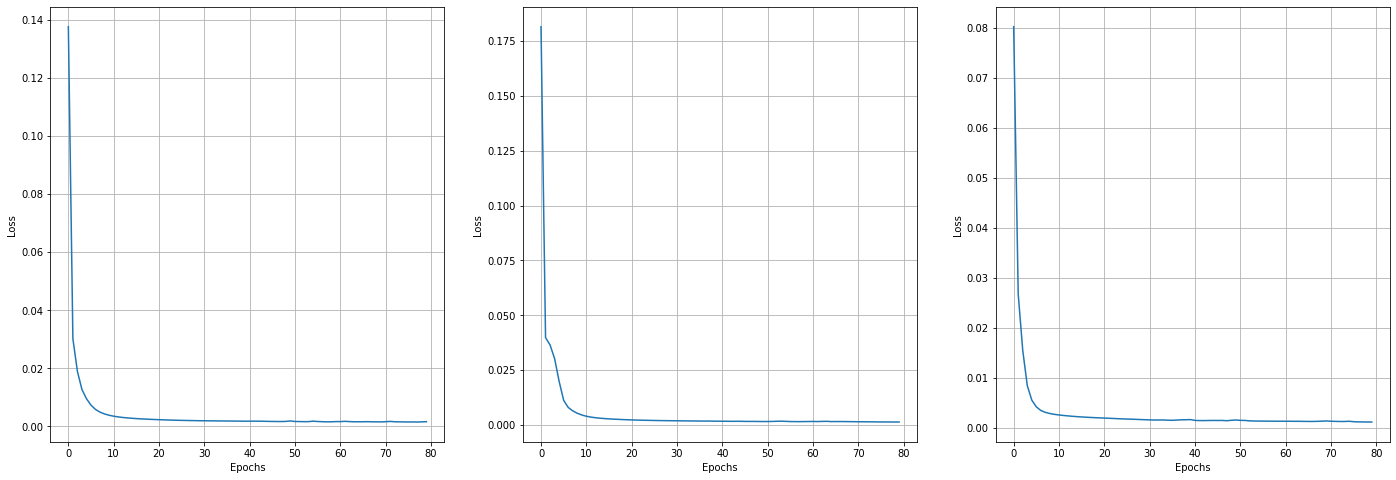

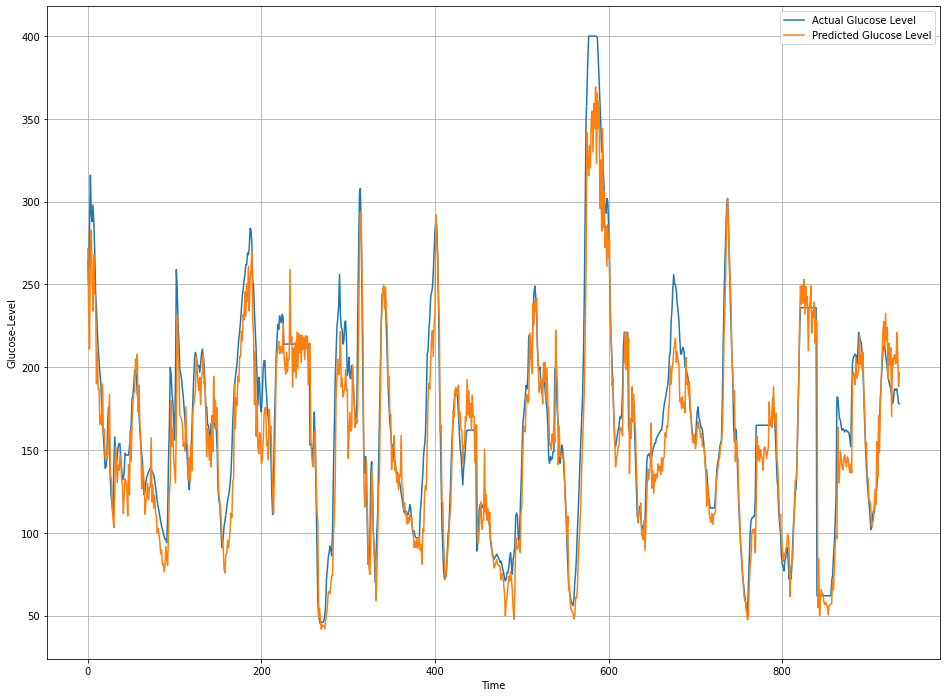

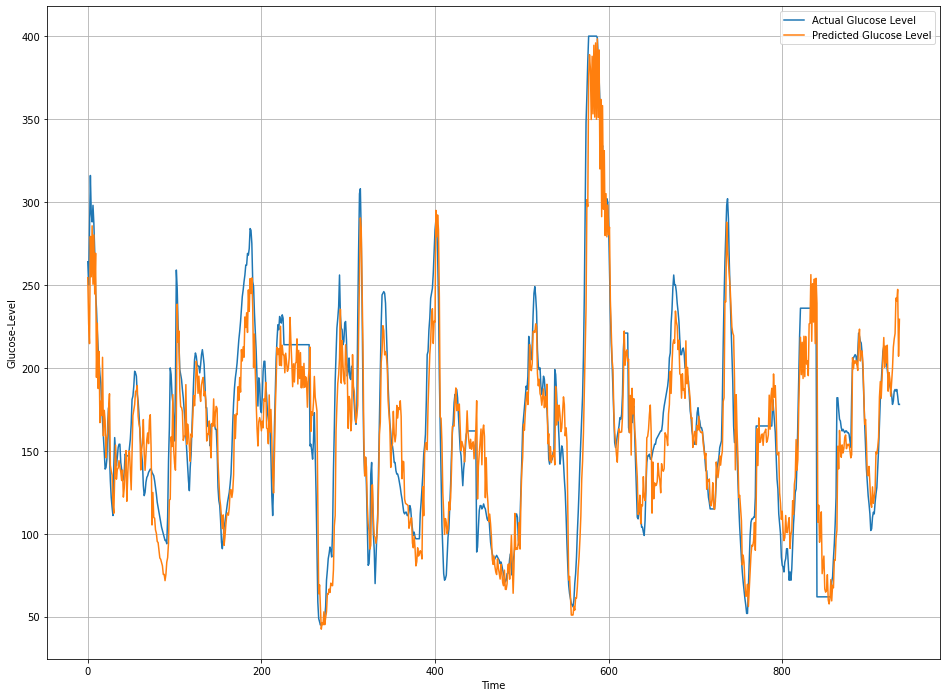

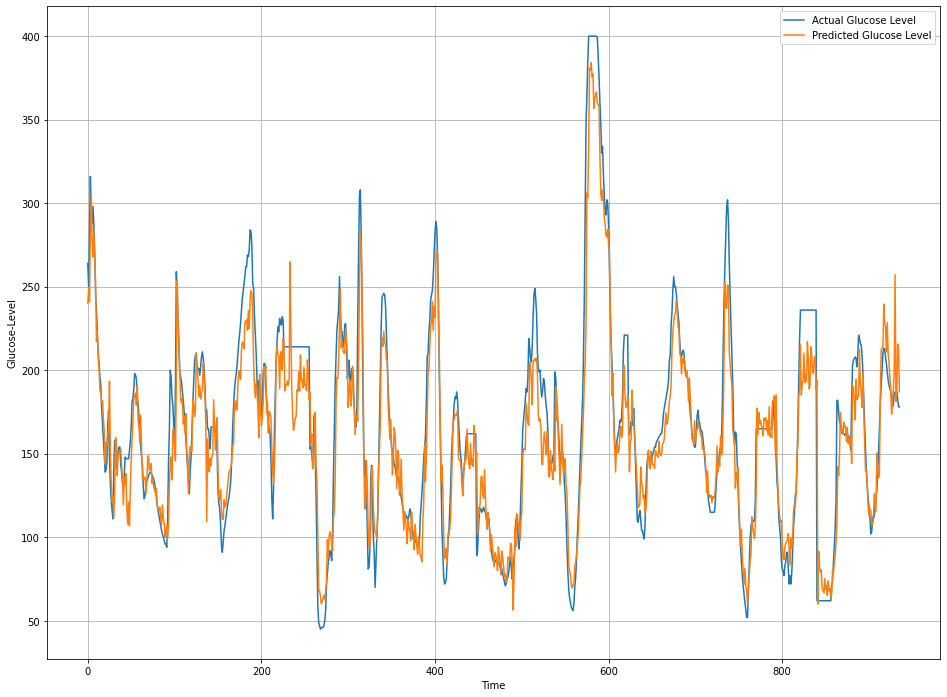

In [13]:
# Consolidated training - Training for all patients and activations

CAUSAL_TRAINING = False
# CAUSAL_FEATURES = ['ts','glucose','heart_Rate','basis_gsr','skin_temperature','air_temperature','basal_insulin','carb',
#                    'bolus_insulin','excersize','hypo','steps','t6','t10','t13','t16','t18','t21','t24']
CAUSAL_FEATURES = ['ts','glucose','heart_Rate','basis_gsr','skin_temperature','air_temperature','basal_insulin','carb','t6','t10','t13','t16','t18','t21','t24']

# patients = [559,563,570, 575, 588]
patients = [559]
NUM_TRIALS = 3
for patient in patients:
  PATIENT_NUMBER = patient

  DATA_FILE = str(PATIENT_NUMBER)+'_train.csv'

  if CAUSAL_TRAINING:
    train_data = pd.read_csv(DATA_FILE,index_col='ts',usecols=CAUSAL_FEATURES)
  else:
    train_data = pd.read_csv(DATA_FILE,index_col='ts')    
    train_data = train_data.rename(columns={'Unnamed: 1':'feature'}).drop(labels=['feature','meal'], axis=1)  
  x_train, y_train, scaler = prepare_dataset(train_data)  

  NUM_FEATURES = x_train.shape[-1]

  dataset = TensorDataset(x_train,y_train)
  dataloader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=False)

  TEST_FILE = str(PATIENT_NUMBER)+'_test.csv'

  if CAUSAL_TRAINING:
    test_data = pd.read_csv(TEST_FILE,index_col='ts',usecols=CAUSAL_FEATURES)    
  else:
    test_data = pd.read_csv(TEST_FILE, index_col='ts')
    test_data = test_data.rename(columns={'Unnamed: 1':'feature'}).drop(labels=['feature','meal'], axis=1)  
  x_test, y_test, scaler = prepare_dataset(test_data)  

  ACTIVATION = 'tanh'
  print(f"Patient - {PATIENT_NUMBER}: Activation - {ACTIVATION}")  
  losses, models = train_model(ACTIVATION,NUM_TRIALS)
  model_performance(models,losses, x_test, y_test)

  ACTIVATION = 'elliot'
  print(f"Patient - {PATIENT_NUMBER}: Activation - {ACTIVATION}")  
  losses, models = train_model(ACTIVATION,NUM_TRIALS)
  model_performance(models,losses, x_test, y_test)

  EPOCHS = 80

  ACTIVATION = 'ptanh'
  print(f"Patient - {PATIENT_NUMBER}: Activation - {ACTIVATION}")  
  losses, models = train_model(ACTIVATION,NUM_TRIALS)
  model_performance(models,losses, x_test, y_test)

  ACTIVATION = 'pelliot'
  print(f"Patient - {PATIENT_NUMBER}: Activation - {ACTIVATION}")  
  losses, models = train_model(ACTIVATION,NUM_TRIALS)
  model_performance(models,losses, x_test, y_test)

In [ ]:
!zip -r /content/559-all.zip /content/iconip-559*.*